<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/ETL/ETL2sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [27]:
!pip install graphviz pydot

In [28]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from IPython.display import Image

In [29]:
%%capture
!wget https://github.com/Dimildizio/DArc_course/raw/main/ETL/99Bikers_Raw_data.xlsx

In [312]:
file_path = '99Bikers_Raw_data.xlsx'

df_transactions = pd.read_excel(file_path, sheet_name='Transactions', index_col = 'transaction_id')
df_customers_demographics = pd.read_excel(file_path, sheet_name='CustomerDemographic', index_col='customer_id')
df_new_customers_list = pd.read_excel(file_path, sheet_name='NewCustomerList')
df_customer_addresses = pd.read_excel(file_path, sheet_name='CustomerAddress', index_col='customer_id')

<ipython-input-312-74b641e7ca2a>:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_customers_demographics = pd.read_excel(file_path, sheet_name='CustomerDemographic', index_col='customer_id')
<ipython-input-312-74b641e7ca2a>:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_new_customers_list = pd.read_excel(file_path, sheet_name='NewCustomerList')


## Create db

In [311]:
!touch mydb.db

In [313]:
conn = sqlite3.connect('mydb.db')

In [314]:
for x in (df_transactions, df_customers_demographics, df_new_customers_list, df_customer_addresses):
  print(x.columns)

Index(['product_id', 'customer_id', 'transaction_date', 'online_order',
       'order_status', 'brand', 'product_line', 'product_class',
       'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')
Index(['address', 'postcode', 'state', 'country', 'property_valuation'], dtype='object')


Drop default as a column with random stuff

In [315]:
if 'default' in df_customers_demographics.columns:
  df_customers_demographics.drop('default', axis=1, inplace=True)
for x in df_new_customers_list.columns:
  if 'Unnamed' in x or x in ['Rank', 'Value']:
    df_new_customers_list.drop(x, axis=1, inplace=True)

In [316]:
df_new_customers_list.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation'],
      dtype='object')

#### Set id indexes for new_customers

In [317]:
idx_start=max(df_customer_addresses.index.max(), df_customers_demographics.index.max())+1
df_new_customers_list['customer_id'] = range(idx_start, idx_start+len(df_new_customers_list))
df_new_customers_list.set_index('customer_id', inplace=True)

In [318]:
for x in (df_transactions, df_customers_demographics, df_new_customers_list, df_customer_addresses):
  display(x.iloc[:1])

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
customer_id,,,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
customer_id,,,,,,,,,,,,,,,,
4004,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6


,address,postcode,state,country,property_valuation
customer_id,,,,,
1,060 Morning Avenue,2016,New South Wales,Australia,10


## Create stage tables

In [319]:
df_transactions.to_sql('STG_TRANSACTIONS', conn, if_exists='replace')
df_customers_demographics.to_sql('STG_CUSTOMERS_DEMOGRAPHICS', conn, if_exists='replace')
df_new_customers_list.to_sql('STG_NEW_CUSTOMERS_LIST', conn, if_exists='replace')
df_customer_addresses.to_sql('STG_CUSTOMER_ADDRESS', conn, if_exists='replace')

3999

In [320]:
conn.close()

#### Check for duplicates in IDs

In [321]:
conn = sqlite3.connect('mydb.db')

# Fetch data from STG_CUSTOMER_ADDRESS and STG_NEW_CUSTOMERS_LIST
query = "SELECT customer_id, address, postcode, state, country, property_valuation FROM STG_CUSTOMER_ADDRESS"
df_customer_address_test = pd.read_sql(query, conn)

query = "SELECT customer_id, address, postcode, state, country, property_valuation FROM STG_NEW_CUSTOMERS_LIST"
df_new_customers_list_test = pd.read_sql(query, conn)


df_combined = pd.concat([df_customer_address_test, df_new_customers_list_test])

# Check for duplicate customer_id values
duplicate_customer_ids = df_combined[df_combined.duplicated(subset=['customer_id'], keep=False)]

if duplicate_customer_ids.empty:
    print("All customer_id values are unique.")
else:
    print("Duplicate customer_id values:")
    print(duplicate_customer_ids)

conn.close()

All customer_id values are unique.


## Create STAGE table queries

In [322]:
create_transactions_table = """
CREATE TABLE IF NOT EXISTS DWH_FACT_TRANSACTIONS (
    transaction_id INTEGER PRIMARY KEY,
    transaction_date DATE,
    product_id VARCHAR(128),
    customer_id VARCHAR(128),
    online_order VARCHAR(128),
    order_status VARCHAR(128),
    brand VARCHAR(128),
    product_line VARCHAR(128),
    product_class VARCHAR(128),
    product_size VARCHAR(128),
    list_price REAL,
    standard_cost REAL,
    product_first_sold_date DATE
);
"""



create_customers_demographic_table = """
CREATE TABLE IF NOT EXISTS DWH_DIM_CUSTOMERS_DEMOGRAPHIC (
    customer_id VARCHAR(128) PRIMARY KEY,
    first_name VARCHAR(128),
    last_name VARCHAR(128),
    gender VARCHAR(128),
    past_3_years_bike_related_purchases INTEGER,
    DOB DATE,
    job_title VARCHAR(128),
    job_industry_category VARCHAR(128),
    wealth_segment VARCHAR(128),
    deceased_indicator VARCHAR(128),
    owns_car VARCHAR(128),
    tenure INTEGER
);
"""


create_customer_addresses_table = """
CREATE TABLE IF NOT EXISTS DWH_DIM_CUSTOMER_ADDRESSES (
    customer_id VARCHAR(128) PRIMARY KEY,
    address VARCHAR(128),
    postcode VARCHAR(128),
    state VARCHAR(128),
    country VARCHAR(128),
    property_valuation INTEGER
);
"""

In [323]:
conn = sqlite3.connect('mydb.db')
cursor = conn.cursor()

cursor.execute(create_transactions_table)
cursor.execute(create_customers_demographic_table)
cursor.execute(create_customer_addresses_table)

conn.commit()
conn.close()

### Insert data

In [324]:
insert_transactions_data = """
INSERT INTO DWH_FACT_TRANSACTIONS (
    transaction_id, transaction_date, product_id, customer_id,
    online_order, order_status, brand, product_line,
    product_class, product_size, list_price, standard_cost,
    product_first_sold_date
)
SELECT
    transaction_id, transaction_date, product_id, customer_id,
    online_order, order_status, brand, product_line,
    product_class, product_size, list_price, standard_cost,
    product_first_sold_date
FROM STG_TRANSACTIONS;
"""


insert_customers_demographic_data = """
INSERT INTO DWH_DIM_CUSTOMERS_DEMOGRAPHIC (
    customer_id, first_name, last_name, gender,
    past_3_years_bike_related_purchases, DOB, job_title,
    job_industry_category, wealth_segment, deceased_indicator,
    owns_car, tenure
)
SELECT
    customer_id, first_name, last_name, gender,
    past_3_years_bike_related_purchases, DOB, job_title,
    job_industry_category, wealth_segment, deceased_indicator,
    owns_car, tenure
FROM STG_CUSTOMERS_DEMOGRAPHICS
UNION ALL
SELECT
    customer_id, first_name, last_name, gender,
    past_3_years_bike_related_purchases, DOB, job_title,
    job_industry_category, wealth_segment, deceased_indicator,
    owns_car, tenure
FROM STG_NEW_CUSTOMERS_LIST;
"""



insert_customer_addresses_data = """
INSERT INTO DWH_DIM_CUSTOMER_ADDRESSES (
    customer_id, address, postcode, state, country,
    property_valuation
)
SELECT
    customer_id, address, postcode, state, country,
    property_valuation
FROM STG_CUSTOMER_ADDRESS
UNION ALL
SELECT
    customer_id, address, postcode, state, country,
    property_valuation
FROM STG_NEW_CUSTOMERS_LIST;"""

In [325]:
conn = sqlite3.connect('mydb.db')
cursor = conn.cursor()

cursor.execute(insert_transactions_data)
cursor.execute(insert_customers_demographic_data)
cursor.execute(insert_customer_addresses_data)

conn.commit()
conn.close()

Also creation_dt and update_dt could be added

In [327]:
conn = sqlite3.connect('mydb.db')
cursor = conn.cursor()

pds = []
for name in ('DIM_CUSTOMERS_DEMOGRAPHIC', 'DIM_CUSTOMER_ADDRESSES'):
  query = f"SELECT * FROM DWH_{name}"
  check_df = pd.read_sql_query(query, conn, index_col='customer_id')
  pds.append(check_df)

query = f"SELECT * FROM DWH_FACT_TRANSACTIONS"
check_df = pd.read_sql_query(query, conn, index_col='transaction_id')
pds.append(check_df)

conn.close()

for df in pds:
  display(df.tail())

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
customer_id,,,,,,,,,,,
4999,Ferdinand,Romanetti,Male,60,1959-10-07 00:00:00,Paralegal,Financial Services,Affluent Customer,N,No,9.0
5000,Burk,Wortley,Male,22,2001-10-17 00:00:00,Senior Sales Associate,Health,Mass Customer,N,No,6.0
5001,Melloney,Temby,Female,17,1954-10-05 00:00:00,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,N,Yes,15.0
5002,Dickie,Cubbini,Male,30,1952-12-17 00:00:00,Financial Advisor,Financial Services,Mass Customer,N,Yes,19.0
5003,Sylas,Duffill,Male,56,1955-10-02 00:00:00,Staff Accountant IV,Property,Mass Customer,N,Yes,14.0


,address,postcode,state,country,property_valuation
customer_id,,,,,
4999,2 Sloan Way,2200,NSW,Australia,7
5000,04 Union Crossing,2196,NSW,Australia,10
5001,33475 Fair Oaks Junction,4702,QLD,Australia,2
5002,57666 Victoria Way,4215,QLD,Australia,2
5003,21875 Grover Drive,2010,NSW,Australia,9


,transaction_date,product_id,customer_id,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
19996,2017-06-24 00:00:00,51,1018,1.0,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19997,2017-11-09 00:00:00,41,127,1.0,Approved,Solex,Road,medium,medium,416.98,312.74,35560.0
19998,2017-04-14 00:00:00,87,2284,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,40410.0
19999,2017-07-03 00:00:00,6,2764,0.0,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216.0
20000,2017-09-22 00:00:00,11,1144,1.0,Approved,Trek Bicycles,Standard,medium,small,1775.81,1580.47,36334.0


#ELSE

In [332]:
engine = create_engine('sqlite:///mydb.db')

In [331]:
graph = pydot.Dot(graph_type='digraph')

In [329]:
conn = sqlite3.connect('mydb.db')
table_schemas = {}
for table_name in ['DWH_DIM_CUSTOMERS_DEMOGRAPHIC', 'DWH_DIM_CUSTOMER_ADDRESSES', 'DWH_FACT_TRANSACTIONS']:
    query = f"PRAGMA table_info({table_name})"
    schema = pd.read_sql_query(query, conn)
    table_schemas[table_name] = schema
conn.close()

In [333]:
for table_name, schema in table_schemas.items():
    table_label = f"{table_name}\n{', '.join(schema['name'])}"
    node = pydot.Node(table_name, label=table_label, shape='box')
    graph.add_node(node)

In [334]:
image_path = 'erd.png'
graph.write_png(image_path)


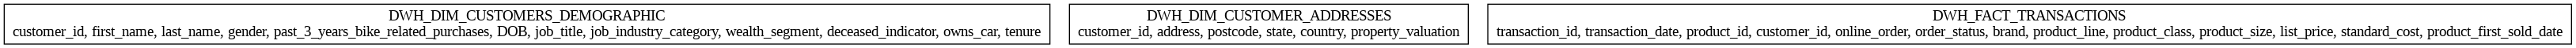

In [335]:
Image(image_path)